In [17]:
!python3 -m pip install powerlaw

In [1]:
import igraph as ig
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import islice
from tqdm import tqdm
import os
from random import sample
import scipy.stats as stats
import powerlaw

In [2]:
## Matplotlib defaults ##
colors = {"1980": "#aa0f35", 
         "1985": "#fdc799",
         "1990": "#abdbfc",
         "1995": "#a0a75c",
         "2000": "#603734",
         "2005": "#009ecb",
         "2010": "#430057",
         "2015": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Degree Analysis

Compare degree distributions & other degree-based stats

## Degree distributions

Comparisons of degree distributions across months

In [12]:
#TESTING - get one month working
cpd_degrees = pickle.load(file=open("Data/Degrees/cpd_degrees_1980-01.p", "rb"))
patent_degrees = pickle.load(file=open("Data/Degrees/patent_degrees_1980-01.p", "rb"))

print(type(cpd_degrees))
print(cpd_degrees[0:10])

<class 'list'>
[1, 84, 5, 2, 1, 14, 6, 1, 55, 4]


In [14]:
#Bastic stats
print(stats.describe(cpd_degrees))
print()
print(stats.describe(patent_degrees))

DescribeResult(nobs=551235, minmax=(1, 596829), mean=289.3535007755313, variance=22220054.09029946, skewness=51.599033457631066, kurtosis=3940.7540822292654)

DescribeResult(nobs=4578946, minmax=(0, 5020), mean=34.833731823873876, variance=4045.377753074271, skewness=7.511152075165203, kurtosis=165.978253118909)


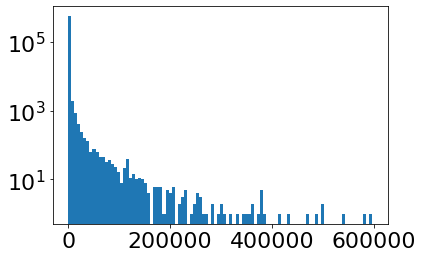

In [11]:
plt.hist(cpd_degrees, bins=100)
plt.yscale("log")

plt.show()

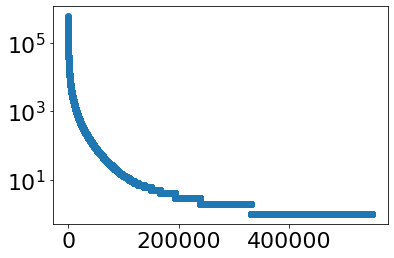

In [36]:
cpd_degrees.sort(reverse=True)

plt.scatter(np.arange(0,len(cpd_degrees),1), cpd_degrees)
plt.yscale("log")

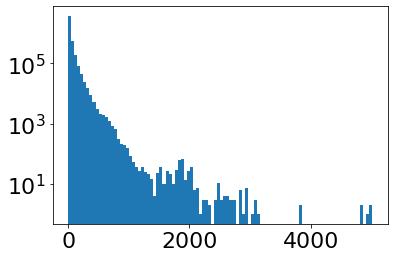

In [15]:
plt.hist(patent_degrees, bins=100)
plt.yscale("log")

plt.show()

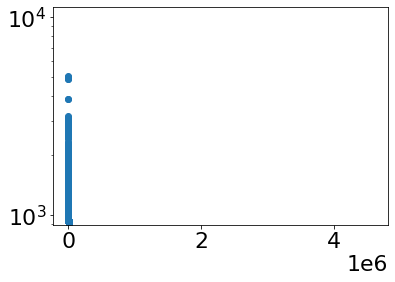

In [37]:
patent_degrees.sort(reverse=True)

plt.scatter(np.arange(0,len(patent_degrees),1), patent_degrees)
plt.yscale("log")

### Powerlaw Testing

In [25]:
#Powerlaw testing
fit = powerlaw.Fit(cpd_degrees)
print(fit)

Calculating best minimal value for power law fit
/usr/local/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


In [32]:
print(fit.power_law.alpha)
print(fit.power_law.sigma)
print(fit.power_law.xmin)

#NOTE: positive R = first fit is better. Negative R = second fit is better. p is the significance in either case.
R, p = fit.distribution_compare('power_law', 'exponential')
print(R, p)
R, p = fit.distribution_compare('power_law', 'lognormal')
print(R, p)

2.113126061345115
0.022566972331619188
11845.0
431.3385623929011 2.3925672195144096e-21
-29.32081248237728 5.435056912214664e-07


<AxesSubplot:>

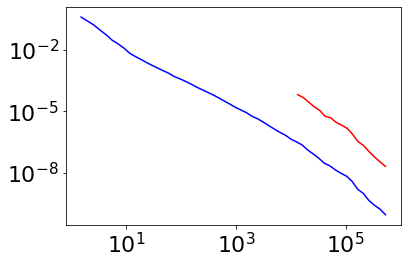

In [30]:
powerlaw.plot_pdf(cpd_degrees, color='b')
fit.plot_pdf(color='r')

# Network Statistics

Nodes, Edges, cpds vs patents, avg degree, max degree, etc...

In [39]:
df = pd.read_csv("Data/NetworkStats/stats_cpdsPatents_1980-01.csv")
print(df)

   Unnamed: 0    Nodes      Edges  Cpd Nodes  Patent Nodes  Avg Degree  \
0           0  5130181  159501777     551235       4578946   62.181735   

   Cpd Avg Degree  Patent Avg Degree  LCC Size  
0      289.353501          34.833732   5035294  


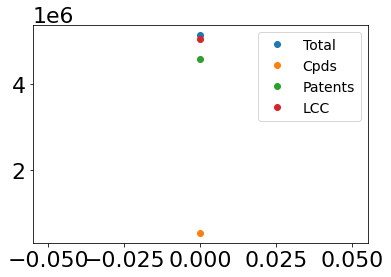

In [51]:
#Plot all sizes on one plot
plt.plot(df["Nodes"], 'o', label="Total", )
plt.plot(df["Cpd Nodes"], 'o', label="Cpds")
plt.plot(df["Patent Nodes"], 'o', label="Patents")
plt.plot(df["LCC Size"], 'o', label="LCC")

plt.legend(prop={"size":14})

## LCC Analysis

Which IDs are present, do they change over time, etc...

*Note:* the lcc_ids file holds *all* clusters. The 0th element holds the largest connected component ids.

In [52]:
lcc_ids_0 = pickle.load(file=open("Data/NetworkStats/lcc_ids_1980-01.p", "rb"))
lcc_ids_1 = pickle.load(file=open("Data/NetworkStats/lcc_ids_1980-02.p", "rb"))
lcc_ids_2 = pickle.load(file=open("Data/NetworkStats/lcc_ids_1980-03.p", "rb"))

**Q1:** How do lcc ids change over time? 

- How do new ids incoporate themselves into the LCC?
- Is there a common percentage added each month?
- Do compounds leave the LCC? (probably unlikely, but worth checking)
- Do compounds originally outside the LCC (not new compounds) get added in?

//TODO (for later): find new ids (data is there, but not explicit) for each month

In [53]:
print("LCC size 0:", len(lcc_ids_0[0]))
print("LCC size 1:", len(lcc_ids_1[0]))
print("LCC size 2:", len(lcc_ids_2[0]))

LCC size 0: 5035294
LCC size 1: 5045106
LCC size 2: 5052457


In [54]:
#Testing
new_ids = list(set(lcc_ids_1[0]) - set(lcc_ids_0[0]))
print("New id size, 0-1:", len(new_ids))

new_ids = list(set(lcc_ids_2[0]) - set(lcc_ids_1[0]))
print("New id size, 1-2:", len(new_ids))

new_ids = list(set(lcc_ids_2[0]) - set(lcc_ids_0[0]))
print("New id size, 0-2:", len(new_ids))

New id size, 0-1: 9812
New id size, 1-2: 7351
New id size, 0-2: 17163


In [55]:
#Find how many newly seen ids are added to the LCC
#1 - build list of all ids seen so far
#2 - find new ids (& save them!)
#3 - percentage of new ids that are added to LCC 

allIds = list(set([id for sublist in lcc_ids_0 for id in sublist]))
lccIds = lcc_ids_0[0]
print(len(allIds))
print(len(lccIds))

5130181
5035294


In [56]:
#All new IDs that month
newIds = list(set([id for sublist in lcc_ids_1 for id in sublist]) - set(allIds))
print(len(newIds)) #TODO: SAVE THESE

#All new LCC IDs that month
newlccIds = list(set(lcc_ids_1[0]) - set(lccIds))
print(len(newlccIds)) #TODO: Save these as well

#Existing compounds which were added to LCC
existing_newlccIds = list(set(newlccIds) - set(newIds))
print(len(existing_newlccIds))

9453
9812
439


In [57]:
# (3) How many of these new ids are in lcc
nonlcc_newIds = list(set(newIds) - set(lcc_ids_1[0])) #Finds the newIds which ARE NOT in the LCC
print("New ids not in LCC:", len(nonlcc_newIds))
print("New ids in LCC:", len(newIds) - len(nonlcc_newIds))
print("Percentage:", float(len(nonlcc_newIds)) / len(newIds))

#How many new LCC ids are NOT new ids?
print("Old compounds joining LCC:", len(existing_newlccIds))
print("Percentage of old compounds joining LCC:", float(len(existing_newlccIds)) / (len(allIds) - len(lccIds)))

New ids not in LCC: 80
New ids in LCC: 9373
Percentage: 0.008462921823759652
Old compounds joining LCC: 439
Percentage of old compounds joining LCC: 0.004626555797949139


In [58]:
allIds.extend(newIds)
print(len(allIds))

lccIds.extend(newlccIds)
print(len(lccIds))

5139634
5045106


In [62]:
#Testing to ensure this works for following months
newIds = list(set([id for sublist in lcc_ids_2 for id in sublist]) - set(allIds))
print(len(newIds)) #TODO: SAVE THESE

#All new LCC IDs that month
newlccIds = list(set(lcc_ids_2[0]) - set(lccIds))
print(len(newlccIds)) #TODO: Save these as well

#Existing compounds which were added to LCC
existing_newlccIds = list(set(newlccIds) - set(newIds))
print(len(existing_newlccIds))

# (3) How many of these new ids are in lcc
nonlcc_newIds = list(set(newIds) - set(lcc_ids_2[0])) #Finds the newIds which ARE NOT in the LCC
print("New ids not in LCC:", len(nonlcc_newIds))
print("New ids in LCC:", len(newIds) - len(nonlcc_newIds))
print("Percentage of new ids in LCC:", 1 - (float(len(nonlcc_newIds)) / len(newIds)))

#How many new LCC ids are NOT new ids?
print("Old compounds joining LCC:", len(existing_newlccIds))
print("Percentage of old compounds joining LCC:", float(len(existing_newlccIds)) / (len(allIds) - len(lccIds)))

6670
7351
737
New ids not in LCC: 56
New ids in LCC: 6614
Percentage of new ids in LCC: 0.9916041979010495
Old compounds joining LCC: 737
Percentage of old compounds joining LCC: 0.007796631685849696


## LCC Graphing

In [20]:
#Read in all LCC data
lcc_df = pd.read_csv("Data/NetworkStats/lcc_stats.csv")
print(lcc_df)

     Unnamed: 0    month  newIds  newIds_newLCC  newIds_nonLCC  oldIds_newLCC  \
0             0  1980-02    9453           9812             80            439   
1             1  1980-03    6670           7351             56            737   
2             2  1980-04   12003          12828             38            863   
3             3  1980-05    7233           7740             21            528   
4             4  1980-06    7788           9071             53           1336   
..          ...      ...     ...            ...            ...            ...   
474         474  2019-08  107354         107343             11              0   
475         475  2019-09   82939          82930             10              1   
476         476  2019-10  124701         124683             18              0   
477         477  2019-11   42714          42707              8              1   
478         478  2019-12   26514          26513              1              0   

     newIdsinLCC_percentage

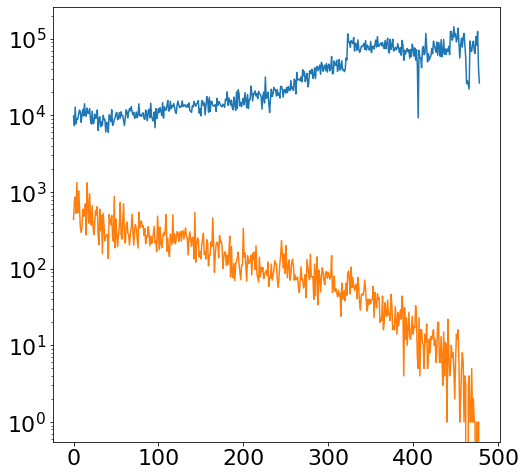

In [25]:
plt.figure(figsize=(8,8))

plt.plot(lcc_df["newIds_newLCC"])
plt.plot(lcc_df["oldIds_newLCC"])

plt.yscale("log")

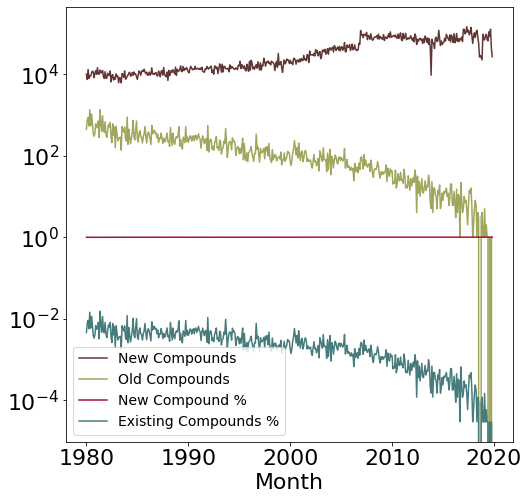

In [27]:
### New compounds added to LCC - either from the set of new compounds or existing compounds

plt.figure(figsize=(8,8))

plt.plot(np.arange(1980, 2020, 1/12)[:-1], lcc_df["newIds_newLCC"], color="#603734", label="New Compounds")
plt.plot(np.arange(1980, 2020, 1/12)[:-1], lcc_df["oldIds_newLCC"], color="#a0a75c", label="Old Compounds")
plt.plot(np.arange(1980, 2020, 1/12)[:-1], lcc_df["newIdsinLCC_percentage"], color="#aa0f35", label="New Compound %")
plt.plot(np.arange(1980, 2020, 1/12)[:-1], lcc_df["oldIdsNewinLCC_percentage"], color="#487c7c", label="Existing Compounds %")

plt.yscale("log")

plt.xlabel("Month")
plt.legend(prop={"size":14})

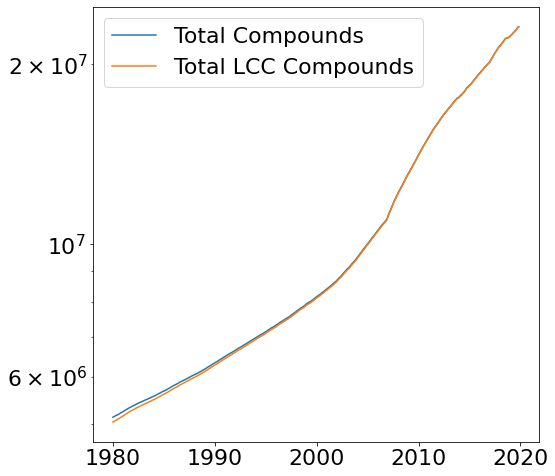

In [29]:
### LCC size vs full amount of compounds (maybe do some percentage differences, but that probably won't be worth it)

plt.figure(figsize=(8,8))

plt.plot(np.arange(1980, 2020, 1/12)[:-1], lcc_df["totalIds"], label="Total Compounds")
plt.plot(np.arange(1980, 2020, 1/12)[:-1], lcc_df["totalLCCIds"], label="Total LCC Compounds")

plt.yscale("log")
plt.legend()